# COVID-19 India Timeseries: A Visualization

This kernel provides a visualization of COVID-19 timeseries data in states of India.

In [1]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import math

In [2]:
# Read data
corona_data = pd.read_csv("..\data\covid19-india-statewise-timeseries.csv",index_col=0, parse_dates=True, dayfirst=True)

# Fill all blank values to 0
corona_data = corona_data.fillna(0);

# Convert all numeric columns to int32
corona_data[['Total Confirmed Cases', 'Cured/Discharged/Migrated','Death']] = corona_data[['Total Confirmed Cases', 'Cured/Discharged/Migrated','Death']].astype('int32')

# Active cases = Confirmed cases - (Cured/Dicharged cases + Deaths)
active_cases = corona_data['Total Confirmed Cases'] - corona_data['Cured/Discharged/Migrated'] - corona_data['Death']

# Add Active cases column to the original data
corona_data.insert(2, 'Active Cases', active_cases)

# Calculate daily change, first sort by date and total confirmed cases
corona_data = corona_data.sort_values(by=['State','Date','Total Confirmed Cases'], ascending=True)
corona_data['Daily Change'] = corona_data.groupby('State')['Total Confirmed Cases'].diff(1)
# For the first reported day, daily change = Confirmed cases
corona_data['Daily Change'].fillna(corona_data['Total Confirmed Cases'], inplace=True)
corona_data[['Daily Change']] = corona_data[['Daily Change']].astype('int32')
# Restore sorting
corona_data = corona_data.sort_values(by=['Date','Total Confirmed Cases'], ascending=True)

# Aggregate the state data datewise to get the national numbers
india_data = corona_data.groupby('Date')['Total Confirmed Cases','Active Cases','Daily Change'].sum().reset_index()
# Calculate 5 day moving average
india_data['5 Day Moving Average'] = india_data['Total Confirmed Cases'].rolling(window=5).mean()
# Take latest 30 day data
# Note: Since the index was reset we cannot use last() method here
india_data=india_data.iloc[-30:].reset_index(drop=True)
india_data['5 Day Moving Average'] = india_data['5 Day Moving Average'].astype('int32')

# Remove first three days as not much infomation there
#corona_data=corona_data[3:]
corona_data=corona_data.last('30D')

C:\Anaconda2\envs\python37\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [3]:
#india_data = corona_data.groupby('Date')['Total Confirmed Cases','Active Cases','Daily Change'].sum().reset_index()

# Get the data for last reported date
full_latest = corona_data.last('1D')

# Sort descending
full_latest = full_latest.sort_values(by=['Active Cases'], ascending=False)

# Get the data for the top 10 states from the lates reported data
top_ten = full_latest[:10]

# Get the list of top 10 states as per the latest data
state_list_top10 = top_ten['State'].unique()

# Get all historical data for top 10 state
corona_data_top10 = corona_data[corona_data['State'].isin(top_ten['State'].tolist())] 

#maha_data = corona_data.sort_values(by=['State','Date','Total Confirmed Cases'], ascending=False)
#maha_data.loc[maha_data['State'] == 'Maharashtra']

The table below summarizes the latest nationwide statistics for India on the last reported date.

In [4]:
summary_data = full_latest.groupby('Date')['Total Confirmed Cases', 'Daily Change', 'Active Cases', 'Cured/Discharged/Migrated', 'Death'].sum().reset_index()
summary_data['Date'] = summary_data['Date'].dt.strftime('%d %B %Y')
summary_data.style.format({"Total Confirmed Cases": "{:,.0f}", "Daily Change": "{:,.0f}", "Active Cases": "{:,.0f}", "Cured/Discharged/Migrated": "{:,.0f}", "Death": "{:,.0f}"})

styles = [
    dict(selector="th", props=[("font-size", "120%"),
                               ("text-align", "center"),
                              ("font-weight", "normal"),
                              ("color", "grey")]),
    dict(selector="td", props=[("font-size", "250%"),
                               ("text-align", "center"),
                              ("background-color", "white"),
                           ("color", "dodgerblue")]),
    #dict(selector=".row_heading, .blank", props=[("display", "none;")])
]

html = (summary_data.style.set_table_styles(styles))
html

C:\Anaconda2\envs\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Date,Total Confirmed Cases,Daily Change,Active Cases,Cured/Discharged/Migrated,Death
0,03 June 2020,200492,8200,94374,100303,5815


Here's the gradient map for statewise cases on the latest reported data.

In [5]:
# latest aggregated data
full_latest_grouped = full_latest.groupby('State')['Total Confirmed Cases', 'Daily Change', 'Active Cases', 'Cured/Discharged/Migrated', 'Death'].sum().reset_index()

full_latest_grouped = full_latest_grouped.sort_values(by='Total Confirmed Cases', ascending=False)
full_latest_grouped = full_latest_grouped.reset_index(drop=True)
full_latest_grouped.style.background_gradient(cmap='mako_r')

C:\Anaconda2\envs\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,State,Total Confirmed Cases,Daily Change,Active Cases,Cured/Discharged/Migrated,Death
0,Maharashtra,72300,2287,38502,31333,2465
1,Tamil Nadu,24586,1091,10683,13706,197
2,Delhi,22132,1298,12333,9243,556
3,Gujarat,17617,417,4631,11894,1092
4,Rajasthan,9373,393,2735,6435,203
5,Madhya Pradesh,8420,137,2835,5221,364
6,Uttar Pradesh,8361,286,3109,5030,222
7,West Bengal,6168,396,3423,2410,335
8,Bihar,4155,229,2185,1946,24
9,Andhra Pradesh,3898,115,1413,2421,64


Here's the active cases trend in India for last 30 days. Eagerly waiting for the curve to "flatten"!!!

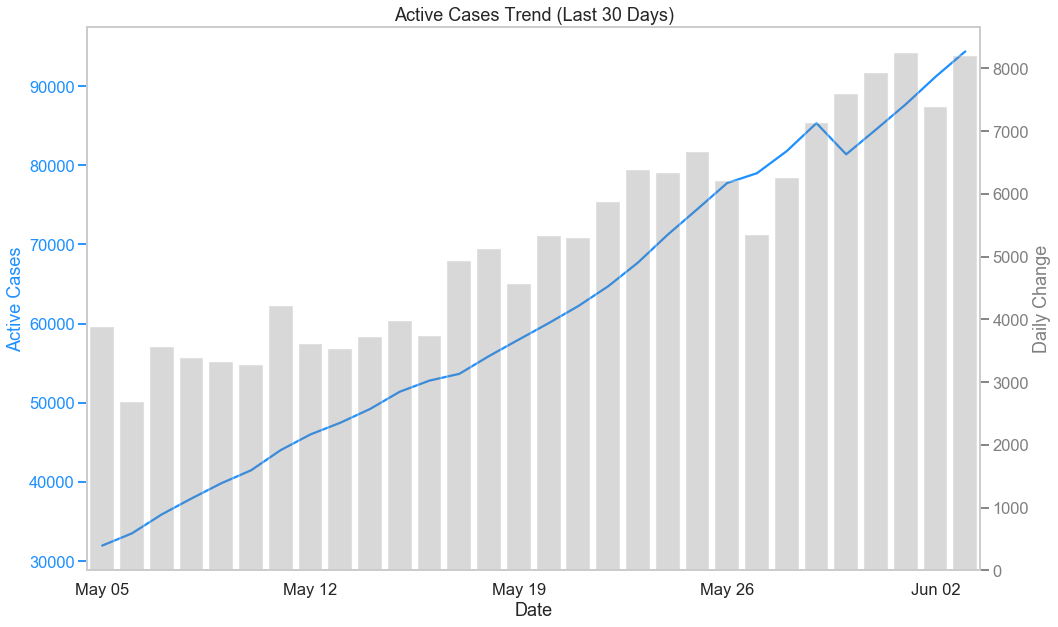

In [6]:
import matplotlib.ticker as ticker

sns.set_style("whitegrid")#, {'xtick.bottom': True, 'xtick.color': '.6'}
sns.set_context("talk", rc={"grid.linewidth": 0.0})

fig, ax1 = plt.subplots(figsize=(16,10))
ax2 = ax1.twinx()

sns.lineplot(x=india_data.index, y='Active Cases', legend=False, hue=None, color="dodgerblue", 
                  data=india_data, ax=ax1)

sns.barplot(x=india_data.index, y='Daily Change', color="gray", alpha=0.3,
            data=india_data, ax=ax2)

ax1.set_xlabel('Date')
ax1.yaxis.label.set_color('dodgerblue')
ax1.tick_params(axis='y', colors='dodgerblue')

ax2.yaxis.label.set_color('gray')
ax2.tick_params(axis='y', colors='gray')

x_labels = india_data['Date'].dt.strftime('%b %d').copy()
for i in range(len(x_labels)):
    if (i % 7) != 0:
        x_labels[i] = ''


ax1.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))

plt.title('Active Cases Trend (Last 30 Days)')

plt.show()


In [7]:
def get_doubling_rate_plot_2(data, doubling_rate):
    y_max = data['Total Confirmed Cases'].max()
    y_min = data['Total Confirmed Cases'].min()
    x_min = data.index.min()
    x_max = data.index.max()
    
    x_d1 = np.empty(0)
    y_d1 = np.empty(0)
    y_d1 = np.append(y_d1, y_min)
    x_d1 = np.append(x_d1, data.index[0]) 
    y_val = y_d1[0]
    k = 0
    while (y_val < y_max):
        y_val = 2 * y_val
        k = k + 1

    y_d1 = np.append(y_d1, y_val/2)
    x = (k-1)*doubling_rate
    if (x > len(india_data)):
        x = len(india_data) - 1
    x_d1 = np.append(x_d1, data.index[x]) 

    return x_d1, y_d1

In [46]:
def plot_doubling_rate(data, doubling_rate, plot):
    y_max = float(data['Total Confirmed Cases'].max())
    y_min = float(data['5 Day Moving Average'].min())
    x_min = float(data.index.min())
    x_max = float(data.index.max())

    x_d1 = np.empty(0)
    y_d1 = np.empty(0)
    x_d1 = np.append(x_d1, x_min) 
    y_d1 = np.append(y_d1, y_min)

    x_2 = doubling_rate * (math.log2(y_max)-math.log2(y_min))
    if (x_2 > x_max):
        y_2 = 2 ** ((x_max/doubling_rate) + math.log2(y_min))
        x_2 = x_max
        #x_2 = doubling_rate * (math.log2(y_2)-math.log2(y_min))
    else:
        y_2 = y_max

    x_d1 = np.append(x_d1, int(x_2))
    y_d1 = np.append(y_d1, int(y_2))

    annotation = str(doubling_rate) + " Days"
    line_index = len(plot.lines)
    plot = sns.lineplot(x=x_d1, y=y_d1, color="grey")
    plot.lines[line_index].set_linestyle("-.")
    plot.annotate(annotation, xy=(x_d1[1], y_d1[1]),color="grey")

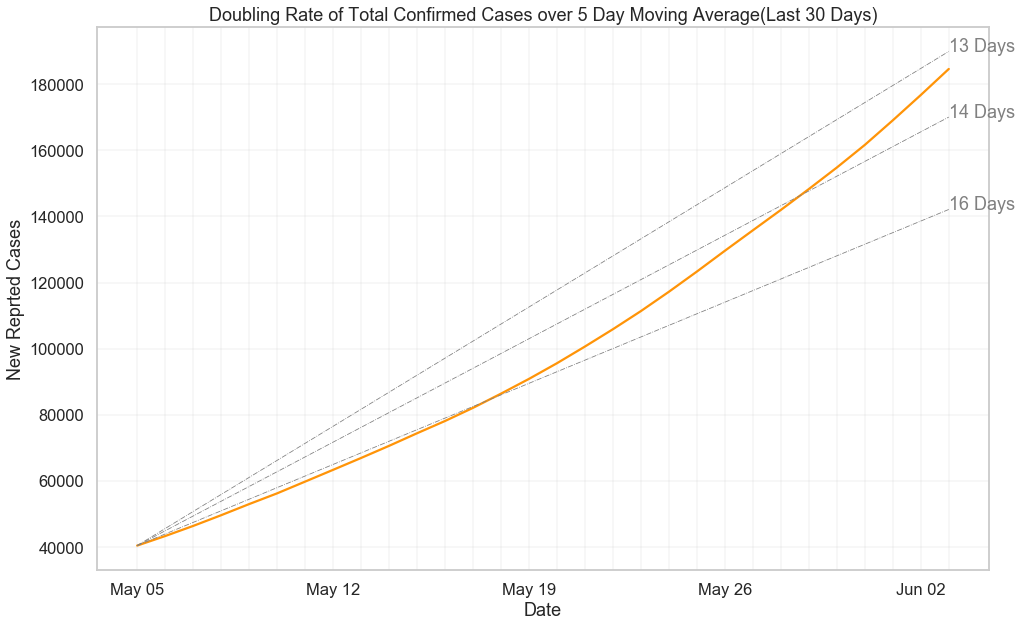

In [47]:
import matplotlib.ticker as ticker
import numpy as np

sns.set_style("whitegrid")#, {'xtick.bottom': True, 'xtick.color': '.6'}
sns.set_context("talk", rc={"grid.linewidth": 0.3})#sns.set(style="ticks", rc={"lines.linewidth": 0.7})

plt.figure(figsize=(16, 10))

plot = sns.lineplot(x=india_data.index, y='5 Day Moving Average', hue=None, color=sns.xkcd_rgb["tangerine"],
                  data=india_data)

sns.set_context(rc={"grid.linewidth": 0.3, "lines.linewidth": 0.8})

# Doubling rate = 13 days
plot_doubling_rate(india_data, 13, plot)

# Doubling rate = 14 days
plot_doubling_rate(india_data, 14, plot)

# Doubling rate = 16 days
plot_doubling_rate(india_data, 16, plot)

x1_labels = india_data['Date'].dt.strftime('%b %d').copy()
for m in range(len(x1_labels)):
    if (m % 7) != 0:
        x1_labels[m] = ''

plot.xaxis.set_major_locator(ticker.FixedLocator(india_data.index))
plot.xaxis.set_major_formatter(ticker.FixedFormatter(x1_labels))

plt.title('Doubling Rate of Total Confirmed Cases over 5 Day Moving Average(Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('New Reprted Cases')
plt.show()

The pie chart below shows the percentage of active cases in each state based on the data reported on the last day.

In [11]:
# Consilidate rest of the states apart from top 10 into a single entry called 'Others'
others_confirmed_sum = full_latest[10:]['Total Confirmed Cases'].sum()
others_active_sum = full_latest[10:]['Active Cases'].sum()

others_data = pd.DataFrame({'State':['Others'], 
                    'Total Confirmed Cases':others_confirmed_sum,  
                    'Active Cases':others_active_sum,
                    'Cured/Discharged/Migrated':0,
                    'Death':0}, index=[top_ten.index[0]]) 

# Add the 'Others' entry to top 10
top_ten_with_others = top_ten.append(others_data)

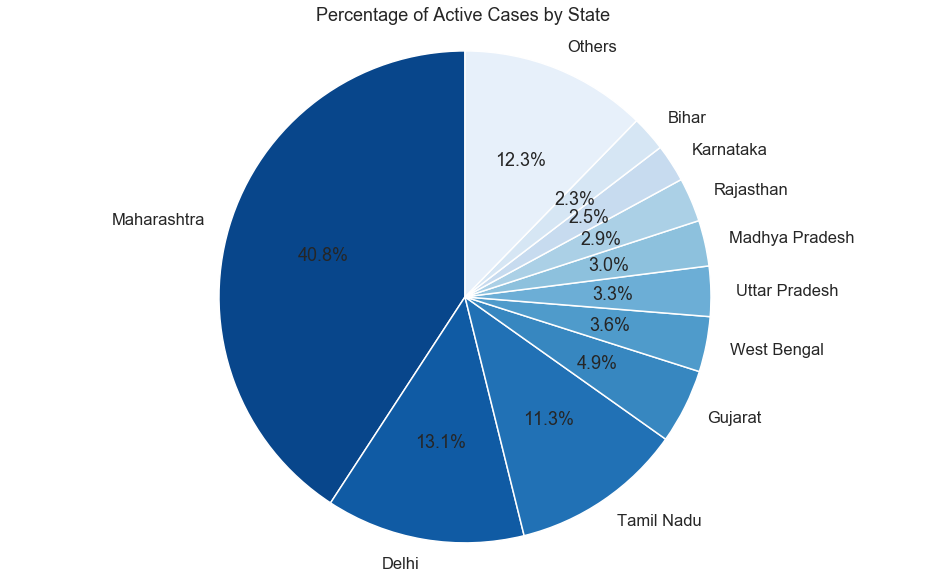

In [12]:
# Plot pie chart to see the percentage of active cases statewise
palette=sns.color_palette("Blues_r", n_colors=11)

# Plot
plt.figure(figsize=(16, 10))
plt.pie(top_ten_with_others['Active Cases'], labels=top_ten_with_others['State'], colors=palette,
autopct='%1.1f%%', shadow=False, startangle=90)

plt.title('Percentage of Active Cases by State')
plt.axis('equal')
plt.show()

Here's the comparitive active cases trend of the top 10 states in last 30 days.

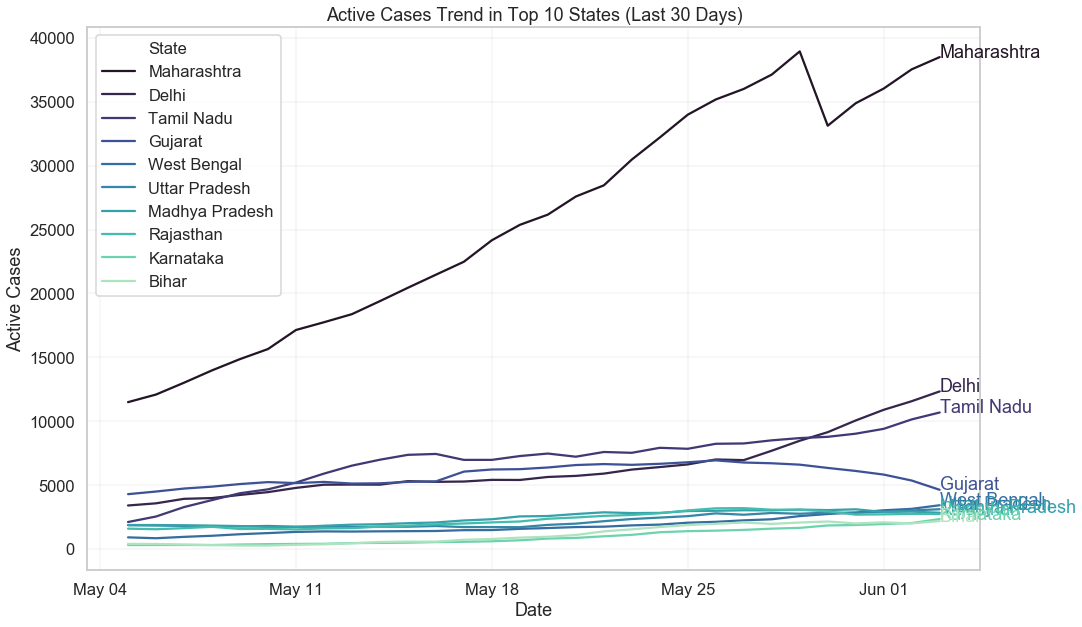

In [13]:
plt.figure(figsize=(16, 10))

palette=sns.color_palette("mako", 10)
sns.set_style("whitegrid")
sns.set_context("talk", rc={"grid.linewidth": 0.3})

plot = sns.lineplot(x=corona_data_top10.index, y="Active Cases", legend='brief',
                  hue="State", hue_order = state_list_top10, palette=palette, 
                  data=corona_data_top10)

# Set x-axis major ticks to weekly interval, on Mondays
plot.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
plot.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

previous_y = 999999999999
x = full_latest['State'].index[0]
for i, state in enumerate(state_list_top10):
    y = full_latest[full_latest['State']==state]['Active Cases'][0]
    # Do not overlap annotations
    if ((previous_y - y) > 70):
        plot.annotate(state, xy=(x, y),color=palette[i])
    previous_y = y

plt.title('Active Cases Trend in Top 10 States (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Active Cases')
plt.show()

...and here's the active cases trend for all states that reported a case.

C:\Anaconda2\envs\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


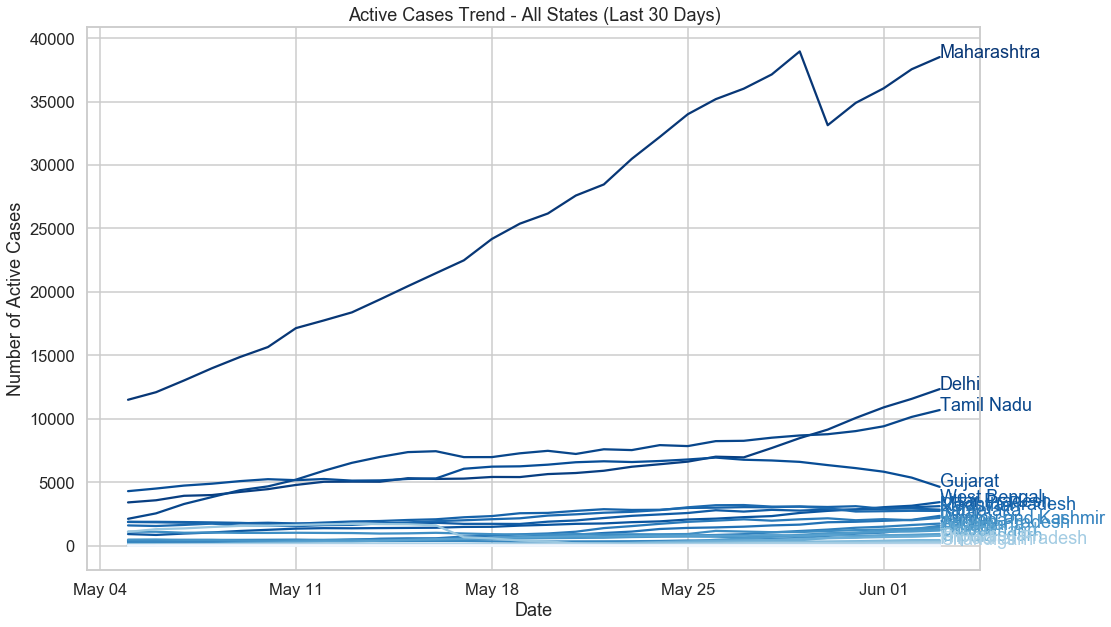

In [14]:
# Get sorted list of states by active cases from the master data. This list will be used as hue_order for linegraph
state_master_sorted = corona_data.groupby('State')['State','Active Cases'].last().sort_values(by='Active Cases', ascending=False)

plt.figure(figsize=(16, 10))

palette=sns.color_palette("Blues_r", corona_data['State'].nunique())
sns.set_context("talk")

plot = sns.lineplot(x=corona_data.index, y="Active Cases", legend=False,
                  hue="State", hue_order = state_master_sorted['State'], palette=palette, 
                  data=corona_data)

# Set x-axis major ticks to weekly interval, on Mondays
plot.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
plot.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

previous_y = 999999999999
x = full_latest['State'].index[0]
for i, state in enumerate(state_master_sorted['State']):
    y = state_master_sorted.loc[state_master_sorted['State'] == state]['Active Cases'][0]
    # Do not overlap annotations
    if ((previous_y - y) > 70):
        plot.annotate(state, xy=(x, y),color=palette[i])
    previous_y = y

plt.title('Active Cases Trend - All States (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Number of Active Cases')
plt.show()